##### Flow:
1. load, reshape and split in test and train all the images
2. instantiate a cnn model 
3. run the model on train and test data to verify how many epochs are more or less needed to get a nice model
4. use that number of epochs to run cross validation (pass the whole 'set_' of images to the cross validation). Repeat from 2 with another model and compare.


- If you notice that you hardly overfit maybe remove/decrease the dropout layers (e.g. from 0.25 to 0.15)
- Try building a model that predicts directly 16x16

In [50]:
%matplotlib inline

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

import matplotlib.pyplot as plt
from datetime import datetime

# keras functions
from keras import callbacks
from keras import preprocessing
from keras.preprocessing import image

# our libraries
from preprocessing import *

from cnn_models import *
from evaluate import *

import scipy as scipy
from mask_to_submission import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Overview
The goal here is to use the CNN to reduce the size of the input image to obtain a "discretized" image of shape, e.g. (W/16, H/16). Every entry of this image is related to a patch in the input image. This obtained image is compared by the CNN with the groundtruth (after properly discretizing by it patch-wise).

### - Load data

In [51]:
# Loaded a set of images
n = 100

imgs, gt_imgs = load_images(n)
imgs[0].shape, gt_imgs[0].shape

Loading 100 images


((400, 400, 3), (400, 400))

### - Reshape the data
We reshape each input to fulfill our cnn inputs and output shape.

In [52]:
# !!! set predict_patch_width in accordance to the model you are using !!!
# the shape of the output of the model depends on the strides parameters 
# (if a layer has stride=2 then each ouput's side is half of the input'side).
# predict_patch_width must be equal to the total reduction of the model, e.g.
# if the model has three layer with stride=2 => the input of the model is 
# reduced by a factor of 2*2*2=8, i.e. the ouptut will be patch-wise with 
# patches 8x8 pixels.
predict_patch_width = 8

X, Y = images_to_XY(imgs, gt_imgs, predict_patch_width=predict_patch_width)

set_ = SimpleNamespace()
set_.X = X
set_.Y = Y

X.shape, Y.shape

((100, 400, 400, 3), (100, 50, 50))

### - For now avoid cross validation, just split the datasest in test and train. 

In [53]:
test_ratio = 0.25

train, test = split_train_test(X, Y, test_ratio=test_ratio, seed=1)
train.X.shape, train.Y.shape, test.X.shape, test.Y.shape 

((75, 400, 400, 3), (75, 50, 50), (25, 400, 400, 3), (25, 50, 50))

In [ ]:
# # check it makes sense (show the i-th input of set_)
# i = 0
# set_ = test

# fig, axs = plt.subplots(1, 2, figsize=(20, 10))
# axs[0].imshow(set_.Y[i, :, :, 1], cmap='gray')
# axs[1].imshow(set_.X[i, :, :])

### - Build the CNN model or load a previous one

- Choose one of the models you defined (with model_n) and initialize it.

In [54]:
# generate an unique name for the model (so to avoid overwriting previous models)
folder_name = "model_"+str('{0:%Y-%m-%d_%H%M%S}'.format(datetime.now()))
model_path = "..\\models\\"+folder_name
model = CnnModel(model_n=1, model_path=model_path)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, None, None, 32)    11648     
_________________________________________________________________
dropout_6 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, None, None, 48)    38448     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, None, None, 48)    57648     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, None, 48)    0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, None, None, 48)    57648     
_________________________________________________________________
conv2d_18 (Conv2D)           (None, None, None, 48)    57648     
__________

- Otherwise load a previous model

In [2]:
# give the folder
folder_name = "model_2017-12-14_194132"
model_path = "..\models\\"+folder_name
model = CnnModel(model_path=model_path)
model.load() # load the model and its weights
model.summary()

Loaded model from disk
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, None, None, 32)    11648     
_________________________________________________________________
dropout_6 (Dropout)          (None, None, None, 32)    0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, None, None, 48)    38448     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, None, None, 48)    57648     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, None, 48)    0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, None, None, 48)    57648     
_________________________________________________________________
conv2d_30 (Conv2D)           (None, None, None, 48)  

### - Train the model on the train data while validating it on the test data

In [ ]:
train.X.shape[0]

In [56]:
# pass a batch size which is a factor of train.shape[0] so that all the batches are fo the same size
num_epochs=100
batch_size=3
_ = model.train(train, test=test, num_epochs=num_epochs, batch_size=batch_size, monitor='val_loss') 

Epoch 1/100
25/25 [==============================] - 12s 484ms/step - loss: 0.5560 - acc: 0.7638 - val_loss: 0.5632 - val_acc: 0.7628
Epoch 2/100
25/25 [==============================] - 11s 444ms/step - loss: 0.5385 - acc: 0.7777 - val_loss: 0.5532 - val_acc: 0.7628
Epoch 3/100
25/25 [==============================] - 11s 445ms/step - loss: 0.5416 - acc: 0.7721 - val_loss: 0.5539 - val_acc: 0.7628
Epoch 4/100
25/25 [==============================] - 11s 444ms/step - loss: 0.5300 - acc: 0.7808 - val_loss: 0.5609 - val_acc: 0.7628
Epoch 5/100
25/25 [==============================] - 11s 443ms/step - loss: 0.5441 - acc: 0.7705 - val_loss: 0.5536 - val_acc: 0.7628
Epoch 6/100
25/25 [==============================] - 11s 450ms/step - loss: 0.5513 - acc: 0.7632 - val_loss: 0.5531 - val_acc: 0.7628
Epoch 7/100
25/25 [==============================] - 11s 445ms/step - loss: 0.5396 - acc: 0.7725 - val_loss: 0.5530 - val_acc: 0.7628
Epoch 8/100
25/25 [==============================] - 11s 445ms

In [57]:
model.save()

Saved model to disk


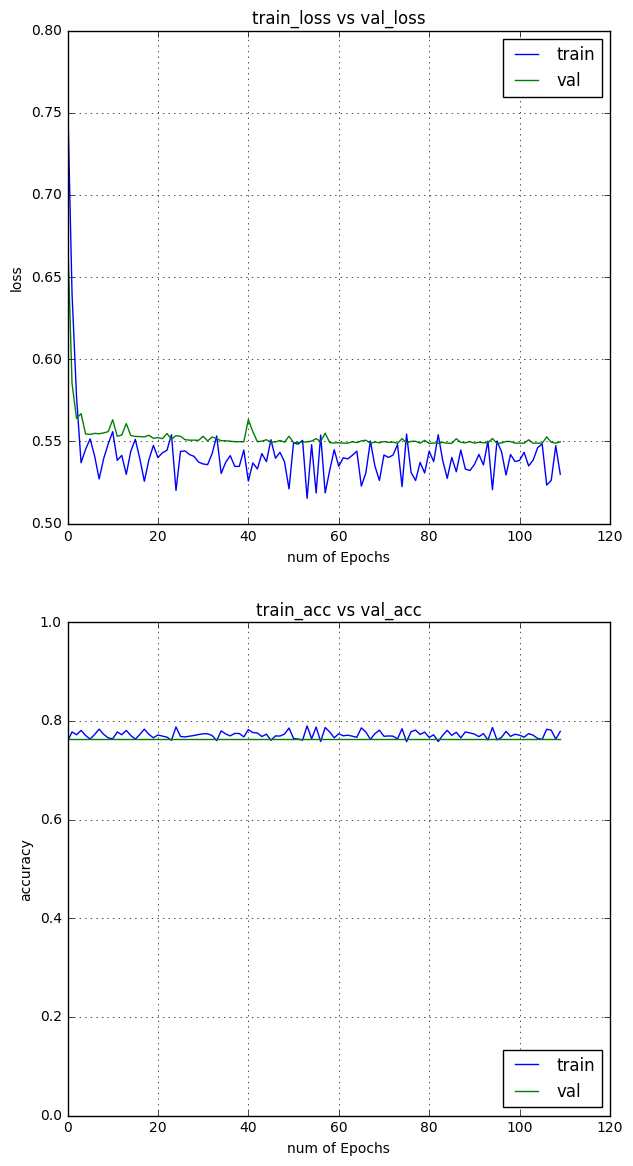

In [58]:
model.plot_history()

### - Run cross validation to evaluate the model

In [ ]:
num_epochs=10
batch_size=3
result = model.cross_validation(set_, batch_size=batch_size, num_epochs=num_epochs)
result

In [ ]:
# plot the histories of the cross validation
plot_history(result["history_mean"]) 
# history of the folds (check if there is a worst case)
# plot_history(result["histories"][0]) 
# plot_history(result["histories"][1]) 
# plot_history(result["histories"][2]) 
# plot_history(result["histories"][3]) 

#### Plot the accuracy and the loss obtained during training

In [ ]:
last_epochs=20 # plot only the last n epochs
model.plot_history(last_epochs=last_epochs)

#### Display the output of a specific layer

In [ ]:
# these are all the layers 
model.model.layers

In [ ]:
# choose a layer and an image 
image = test.X[0]
layer_num = 8

model.show_layer_output(image, layer_num, filename="") # pass a filename if you want to store the image to file 

### - Evaluate the model on the test data

In [60]:
#re-evaluate on some subset
test_ratio = 0.10
train, test = split_train_test(X, Y, test_ratio=test_ratio, seed=1)

C:\Program Files\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


                precision    recall  f1-score   support

0 (background)       0.73      1.00      0.84     18170
      1 (road)       0.00      0.00      0.00      6830

   avg / total       0.53      0.73      0.61     25000

Confusion matrix, without normalization


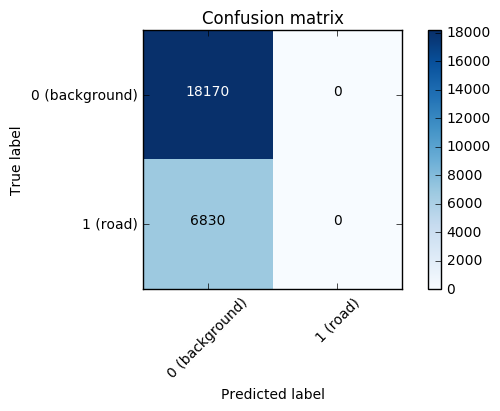

Normalized confusion matrix


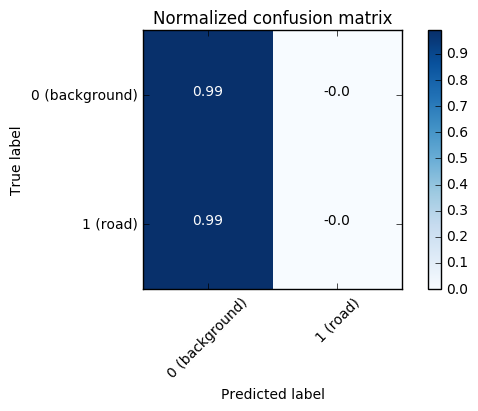

In [61]:
# check the performance on train or test


set_ = test

model.evaluate_model(set_.X, set_.Y)

In [102]:
#and reset the train set as full dataset
test_ratio = 0.0
train, test = split_train_test(X, Y, test_ratio=test_ratio, seed=1)

### - Show a prediction

In [4]:
# choose an image to predict (or part of it)
img = train.X[0][:, :]

model.display_prediction(img, ax=None)

NameError: name 'train' is not defined

### Export predictions


In [47]:
from cnn_models import *
model.predict_and_export()

Loading 5 images to predict
loading image ../dataset/test_set_images/test_1/test_1.png
loading image ../dataset/test_set_images/test_2/test_2.png
loading image ../dataset/test_set_images/test_3/test_3.png
loading image ../dataset/test_set_images/test_4/test_4.png
loading image ../dataset/test_set_images/test_5/test_5.png
(5, 76, 76)
Loading 5 images to predict
loading image ../dataset/test_set_images/test_6/test_6.png
loading image ../dataset/test_set_images/test_7/test_7.png
loading image ../dataset/test_set_images/test_8/test_8.png
loading image ../dataset/test_set_images/test_9/test_9.png
loading image ../dataset/test_set_images/test_10/test_10.png


C:\Program Files\Anaconda3\lib\site-packages\imageio\core\util.py:78: UserWarning: Lossy conversion from float64 to uint8, range [0, 1]
  dtype_str, out_type.__name__))


(5, 76, 76)
Loading 5 images to predict
loading image ../dataset/test_set_images/test_11/test_11.png
loading image ../dataset/test_set_images/test_12/test_12.png
loading image ../dataset/test_set_images/test_13/test_13.png
loading image ../dataset/test_set_images/test_14/test_14.png
loading image ../dataset/test_set_images/test_15/test_15.png
(5, 76, 76)
Loading 5 images to predict
loading image ../dataset/test_set_images/test_16/test_16.png
loading image ../dataset/test_set_images/test_17/test_17.png
loading image ../dataset/test_set_images/test_18/test_18.png
loading image ../dataset/test_set_images/test_19/test_19.png
loading image ../dataset/test_set_images/test_20/test_20.png
(5, 76, 76)
Loading 5 images to predict
loading image ../dataset/test_set_images/test_21/test_21.png
loading image ../dataset/test_set_images/test_22/test_22.png
loading image ../dataset/test_set_images/test_23/test_23.png
loading image ../dataset/test_set_images/test_24/test_24.png
loading image ../dataset/t

### - Save/load model

In [ ]:
model.save()

### - Others

In [ ]:
# some callbacks example: 

# create a list of callbacks we want to use during training
# # a callback to store epoch results to a csv file
# filename='model_train_new.csv'
# csv_log = callbacks.CSVLogger(filename, separator=',', append=False)

# # a callback to stob before doing the predefined number of epochs (stop before overfitting the data)
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='min')

# # a callback to save the best model (best model = the one with the lowest 'monitor' variable)
# filepath = "best-weights-{epoch:03d}-{loss:.4f}-{acc:.4f}.hdf5"
# checkpoint = callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# # callbacks_list = [csv_log,early_stopping,checkpoint]

print(
    "-get configurations:", "\n",
    model.get_config(), "\n",
    model.layers[0].get_config(), "\n",

    "\n-get shapes", "\n",
    model.layers[0].input_shape, "\n",
    model.layers[0].output_shape, "\n",
    
    "\n-get weights", "\n",
    model.layers[0].get_weights()[0].shape, "\n",
    
    "\n-check if trainable", "\n",
    model.layers[0].trainable, "\n", # you can set this to false to "freeze" a layer
)

In [ ]:
from IPython.core.debugger import Pdb
debugger = Pdb()
debugger.set_trace() # put this line as a breakpoint

Test batch generation

In [ ]:
gen1, gen2 = image_generators(X, Y) 

In [ ]:
from cnn_models import batches_generator
j = 0
x_batches = []
y_batches = []

for x, y in batches_generator(X[:4], Y[:4], batch_size = 4):
    j += 1
    if j > 10:
        break
    x_batches.append(x)
    y_batches.append(y)

In [ ]:
np.array(x_batches).shape, np.array(y_batches).shape

In [ ]:
b = 0
i = -1

In [ ]:
i += 1
if i >= x_batches[0].shape[0]:
    i = 0
    b += 1
print("Batch", str(b) + ". Image", i)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches((20, 10))
axs[0].imshow(x_batches[b][i], cmap='gray')
axs[1].imshow(y_batches[b][i][:, :, 1], cmap='gray')